#  2017-11-24  Tree-based methods

The goal of this lab is to explore and understand tree-based models on classification problems.

We will focus successively on decision trees, bagging trees and random forests. The first Bonus part guides you in implementing these algortihms yourself. The second Bonus part shows you how to use tree-based methods for feature selection.

### Import required libraries

In [1]:
# import required libraries
import numpy as np
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

### Classification data
We will use the same data as in Lab 4: the samples are tumors, each described by the expression (= the abundance) of 3,000 genes. The goal is to separate the endometrium tumors from the uterine ones.

In [2]:
# load the endometrium vs. uterus tumor data
endometrium_data = pd.read_csv('data/small_Endometrium_Uterus.csv', sep=",")  # load data
endometrium_data.head(n=5)  # adjust n to view more data

,ID_REF,1554530_at,1553185_at,1554340_a_at,1556202_at,1553957_at,1555469_a_at,1553660_at,1554681_a_at,1554938_a_at,...,1553967_at,1553362_at,1553002_at,1556194_a_at,1556420_s_at,1555855_at,1554508_at,1555097_a_at,1556371_at,Tissue
0,117722,10.8,13233.7,27.2,167.8,450.7,283.8,6.4,8.6,26.7,...,165.2,43.7,77.0,42.2,154.8,266.6,444.0,66.9,50.6,Endometrium
1,76638,12.6,4986.8,1.7,221.1,380.8,394.3,121.2,8.0,153.8,...,190.7,3.2,84.0,183.0,288.0,20.6,99.3,6.4,12.2,Endometrium
2,88952,16.6,6053.8,121.4,342.7,217.6,367.9,159.7,10.8,124.4,...,95.9,17.1,72.3,292.9,209.5,11.6,51.3,33.8,33.4,Endometrium
3,76632,9.9,6109.1,23.0,139.3,501.8,289.9,101.7,9.7,204.8,...,235.1,37.9,81.5,109.3,537.7,58.7,73.9,58.9,15.4,Endometrium
4,88966,13.1,8430.9,17.4,29.4,449.1,248.2,104.1,11.2,94.5,...,125.0,59.9,186.8,122.5,355.2,65.1,139.9,14.1,11.2,Endometrium


In [3]:
# Create the design matrix and target vector
X = endometrium_data.drop(['ID_REF', 'Tissue'], axis=1).values
y = pd.get_dummies(endometrium_data['Tissue']).values[:,1]

In [4]:
## make folds
from sklearn import model_selection
skf = model_selection.StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
folds = [(tr,te) for (tr,te) in skf.split(X, y)]

### Cross-validation procedures

In [5]:
def cross_validate_clf(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        classifier.fit(design_matrix[tr,:], labels[tr])
        pos_idx = list(classifier.classes_).index(1)
        pred[te] = (classifier.predict_proba(design_matrix[te,:]))[:, pos_idx]
    return pred

In [6]:
def cross_validate_clf_optimize(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        classifier.fit(design_matrix[tr,:], labels[tr])
        print(classifier.best_params_)
        pos_idx = list(classifier.best_estimator_.classes_).index(1)
        pred[te] = (classifier.predict_proba(design_matrix[te,:]))[:, pos_idx]
    return pred

# 1. Decision Trees
A decision tree predicts the value of a target variable by learning simple decision rules inferred from the data features.

In scikit-learn, they are implemented in [tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for classification and [tree.DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) for regression.

In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

## 1.1 Toy dataset
In order to better understand how a decision tree processes the feature space, we will first work on a simulated dataset. 

/home/clementgauchy/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


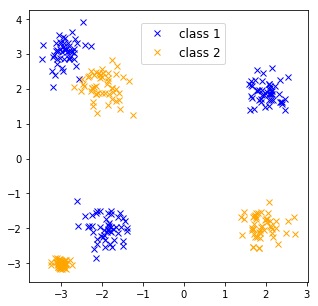

In [8]:
plt.figure(figsize=(5, 5))

x1 = np.random.multivariate_normal([2,2], [[0.1,0],[0,0.1]], 50)
x2 = np.random.multivariate_normal([-2,-2], [[0.1,0],[0,0.1]], 50)
x3 = np.random.multivariate_normal([-3,3], [[0.1,0.1],[0,0.1]], 50)
X1 = np.concatenate((x1,x2,x3), axis=0)

y1 = np.random.multivariate_normal([-2,2], [[0.1,0],[0,0.1]], 50)
y2 = np.random.multivariate_normal([2,-2], [[0.1,0],[0,0.1]], 50)
y3 = np.random.multivariate_normal([-3,-3], [[0.01,0],[0,0.01]], 50)
X2 = np.concatenate((y1,y2,y3), axis=0)

plt.plot(X1[:,0],X1[:,1], 'x', color='blue', label='class 1')
plt.plot(X2[:,0], X2[:,1], 'x', color='orange', label='class 2')


plt.legend(loc=(0.4, 0.8), fontsize=12)

**Question:** What do you expect the decision boudaries to look like ? 

__Answer:__

__Question:__ Fill-in the following code to train a decision tree on this toy data and visualize it. 

Change the splitter to random, meaning that the algorithm will consider the feature along which to split _randomly_ (rather than picking the optimal one), and then select the best among several _random_ splitting point. Run the algorithm several times. What do you observer?

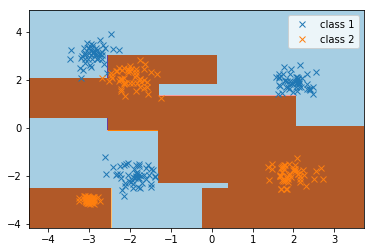

In [10]:
# Training data
X_demo = np.concatenate((X1, X2), axis=0)
y_demo = np.concatenate((np.zeros(X1.shape[0]), np.ones(X2.shape[0])))

# Train a DecisionTreeClassifier on the training data
clf = DecisionTreeClassifier()
clf.fit(X_demo,y_demo)

# Create a mesh, i.e. a fine grid of values between the minimum and maximum
# values of x1 and x2 in the training data
plot_step = 0.02
x_min, x_max = X_demo[:, 0].min() - 1, X_demo[:, 0].max() + 1
y_min, y_max = X_demo[:, 1].min() - 1, X_demo[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

# Label each point of the mesh with the trained DecisionTreeClassifier
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contours corresponding to these labels 
# (i.e. the decision boundary of the DecisionTreeClassifier)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# Plot the training data 
plt.plot(X1[:,0], X1[:,1], 'x', label='class 1')
plt.plot(X2[:,0], X2[:,1], 'x', label='class 2')
plt.legend()

## 1.2 Tumor classification data

Let us now go back to our tumor classification problem.

**Question:** Cross-validate 5 different decision trees (with default parameters) and print out their accuracy. Why do you get different values? Check the documentation for help.

In [11]:
from sklearn import tree
from sklearn import metrics

ypred_dt = [] # will hold the 5 arrays of predictions (1 per tree)
for tree_index in range(5):
    # Initialize a DecisionTreeClassifier
    clf = DecisionTreeClassifier()
    
    # Cross-validate this DecisionTreeClassifier on the toy data
    pred_proba = cross_validate_clf(X, y, clf, folds)
    
    # Append the prediction to ypred_dt 
    ypred_dt.append(pred_proba)
    
    # Print the accuracy of DecisionTreeClassifier
    print("%.3f" % metrics.accuracy_score(y, np.where(pred_proba > 0.5, 1, 0)))

0.596
0.585
0.552
0.585
0.563


__Answer:__

**Question:** Compute the mean and standard deviation of the area under the ROC curve of these 5 trees. Plot the ROC curves of these 5 trees.

Use the [metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module of scikit-learn.

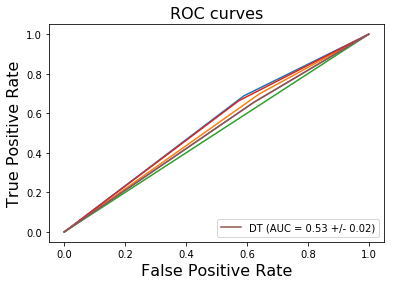

In [49]:
fpr_dt = [] # will hold the 5 arrays of false positive rates (1 per tree)
tpr_dt = [] # will hold the 5 arrays of true positive rates (1 per tree)
auc_dt = [] # will hold the 5 areas under the ROC curve (1 per tree)


for tree_index in range(5):
    # Compute the ROC curve of the current tree
    fpr_dt_tmp, tpr_dt_tmp, thresholds =  metrics.roc_curve(y,ypred_dt[tree_index])
    # Compute the area under the ROC curve of the current tree
    auc_dt_tmp = metrics.auc(fpr_dt_tmp, tpr_dt_tmp)
    fpr_dt.append(fpr_dt_tmp)
    tpr_dt.append(tpr_dt_tmp)
    auc_dt.append(auc_dt_tmp)

# Plot the first 4 ROC curves
for tree_index in range(5):
    plt.plot(fpr_dt[tree_index],tpr_dt[tree_index]) 
            
# Plot the last ROC curve, with a label that gives the mean/std AUC
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', 
         label='DT (AUC = %0.2f +/- %0.2f)' % (np.mean(auc_dt), np.std(auc_dt)))

# Plot the ROC curve
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right")

**Question:** What parameters of DecisionTreeClassifier can you play with to define trees differently than with the default parameters? Cross-validate these using a grid search with [model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Plot the optimal decision tree on the previous plot. Did you manage to improve performance?

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5}
{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 16}
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 17}
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 4}
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 15}


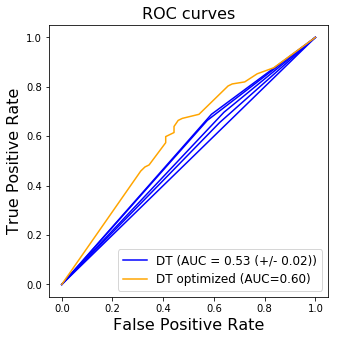

In [51]:
from sklearn import model_selection

# Define the grid of parameters to test
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': np.arange(1,10),
    'min_samples_leaf': np.arange(1,20)
}

# Initialize a GridSearchCV object that will be used to cross-validate
# a DecisionTreeClassifier with these parameters.
# What scoring function do you want to use?
clf = model_selection.GridSearchCV(DecisionTreeClassifier(),param_grid)

# Cross-validate the GridSearchCV object 
ypred_dt_opt = cross_validate_clf_optimize(X, y, clf, folds)

# Compute the ROC curve for the optimized DecisionTreeClassifier
fpr_dt_opt, tpr_dt_opt, thresholds = metrics.roc_curve(y, ypred_dt_opt, pos_label=1)
auc_dt_opt = metrics.auc(fpr_dt_opt, tpr_dt_opt)

# Plot the ROC curves of the 5 decision trees from earlier
fig = plt.figure(figsize=(5, 5))

for tree_index in range(4):
    plt.plot(fpr_dt[tree_index], tpr_dt[tree_index], '-', color='blue') 
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', color='blue', 
         label='DT (AUC = %0.2f (+/- %0.2f))' % (np.mean(auc_dt), np.std(auc_dt)))

# Plot the ROC curve of the optimized DecisionTreeClassifier
plt.plot(fpr_dt_opt, tpr_dt_opt, color='orange', label='DT optimized (AUC=%0.2f)' % auc_dt_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

## 4.2 Bagging trees

We will resort to ensemble methods to try to improve the performance of single decision trees. Let us start with _bagging trees_: The different trees are to be built using a _bootstrap sample_ of the data, that is to say, a sample built by randomly drawing n points _with replacement_ from the original data, where n is the number of points in the training set.

Bagging is efficient when used with low bias and high variance weak learners. Indeed, by averaging such estimators, we lower the variance by obtaining a smoother estimator, which is still centered around the true density (low bias). 

Bagging decision trees hence makes sense, as decision trees have:
* low bias: intuitively, the conditions that are checked become multiplicative so the tree is continuously narrowing down on the data (the tree becomes highly tuned to the data present in the training set).
* high variance: decision trees are very sensitive to where it splits and how it splits. Therefore, even small changes in input variable values might result in very different tree structure.


**Note**: Bagging trees and random forests start being really powerful when using large number of trees (several hundreds). This is computationally more intensive, especially when the number of features is large, as in this lab. For the sake of computational time, we suggeste using small numbers of trees, but you might want to repeat this lab for larger number of trees at home.

**Question** Cross-validate a bagging ensemble of 5 decision trees on the data. Plot the resulting ROC curve, compared to the 5 decision trees you trained earlier.

Use [ensemble.BaggingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html).

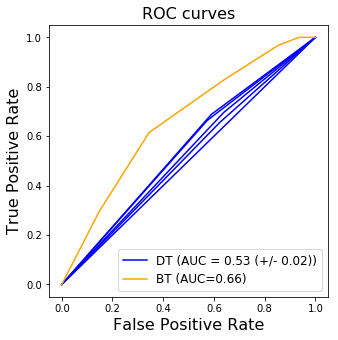

In [54]:
from sklearn import ensemble

# Initialize a bag of trees
clf = ensemble.BaggingClassifier(n_estimators=5)

# Cross-validate the bagging trees on the tumor data
ypred_bt = cross_validate_clf(X, y, clf, folds)

# Compute the ROC curve of the bagging trees
fpr_bt, tpr_bt, thresholds = metrics.roc_curve(y, ypred_bt, pos_label=1)
auc_bt = metrics.auc(fpr_bt, tpr_bt)

# Plot the ROC curve of the 5 decision trees from earlier
fig = plt.figure(figsize=(5, 5))

for tree_index in range(4):
    plt.plot(fpr_dt[tree_index], tpr_dt[tree_index], '-', color='blue') 
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', color='blue', 
         label='DT (AUC = %0.2f (+/- %0.2f))' % (np.mean(auc_dt), np.std(auc_dt)))

# Plot the ROC curve of the bagging trees
plt.plot(fpr_bt, tpr_bt, color='orange', label='BT (AUC=%0.2f)' % auc_bt)


plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

__Question:__ How do the bagging trees perform compared to individual trees?
    
__Answer:__

**Question** Use cross_validate_optimize to optimize the number of decision trees to use in the bagging method. How many trees did you find to be an optimal choice?

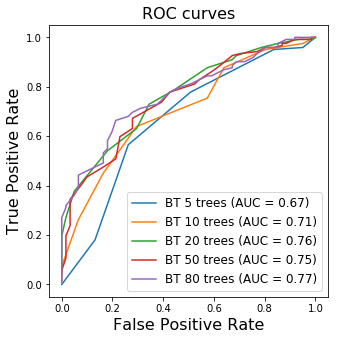

In [57]:
# Number of trees to use
list_n_trees = [5, 10, 20, 50, 80]

# Start a ROC curve plot
fig = plt.figure(figsize=(5, 5))
    
for idx, n_trees in enumerate(list_n_trees):
    # Initialize a bag of trees with n_trees trees
    clf = ensemble.BaggingClassifier(n_estimators=n_trees)
    
    # Cross-validate the bagging trees on the tumor data
    ypred_bt_tmp = cross_validate_clf(X, y, clf, folds)
    
    # Compute the ROC curve 
    fpr_bt_tmp, tpr_bt_tmp, thresholds = metrics.roc_curve(y, ypred_bt_tmp, pos_label=1)
    auc_bt_tmp = metrics.auc(fpr_bt_tmp, tpr_bt_tmp)

    # Plot the ROC curve
    plt.plot(fpr_bt_tmp, tpr_bt_tmp, '-', 
             label='BT %0.f trees (AUC = %0.2f)' % (n_trees, auc_bt_tmp))

# Plot the ROC curve of the optimal decision tree
#plt.plot(fpr_dt_opt, tpr_dt_opt, color=cmap(i), label='DT optimized (AUC=%0.2f)' % auc_dt_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

## 3. Random Forest

In practice, simply bagging is typically not enough. In order to get a good reduction in variance, we require that the models being aggregated be uncorrelated, so that they make “different errors”. Bagging will usually get you highly correlated models that will make the same errors, and will therefore not reduce the variance of the combined predictor.

**Question** What is the difference between bagging trees and random forests? How does it intuitively fix the problem of correlations between trees ? 

__Answer:__

**Question** Cross-validate a random forest of 5 decision trees on the data. Plot the resulting ROC curve, compared to the bagging tree made of 5 decision trees.

Use [ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# Initialize a random forest with 5 trees
clf = ensemble.RandomForestClassifier()

# Cross-validate the random forest on the tumor data
ypred_rf = # TODO

# Compute the ROC curve of the random forest
fpr_rf, tpr_rf, thresholds = # TODO
auc_rf = # TODO

# Plot the ROC curve of the 5 decision trees from earlier
fig = plt.figure(figsize=(5, 5))

for tree_index in range(4):
    plt.plot(fpr_dt[tree_index], tpr_dt[tree_index], '-', color='grey') 
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', color='grey', 
         label='DT (AUC = %0.2f (+/- %0.2f))' % (np.mean(auc_dt), np.std(auc_dt)))

# Plot the ROC curve of the bagging trees (5 trees)
plt.plot(fpr_bt, tpr_bt, label='BT (AUC=%0.2f)' % auc_bt)

# Plot the ROC curve of the random forest (5 trees)
plt.plot(fpr_rf, tpr_rf, label='BT (AUC=%0.2f)' % auc_bt)


plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

**Question** What are the main parameters of Random Forest which can be optimized ?

__Answer:__ 

**Question** Use cross_validate_clf_optimize to optimize 
* the number of decision trees 
* the number of features to consider at each split.

How many trees do you find to be an optimal choice? How does the optimal random forest compare to the optimal bagging trees? How do the training times of the random forest and the bagging trees compare?

In [ ]:
# Define the grid of parameters to test
param_grid = # TODO

# Initialize a GridSearchCV object that will be used to cross-validate
# a random forest with these parameters.
# What scoring function do you want to use?
clf = grid_search.GridSearchCV(# TODO

# Cross-validate the GridSearchCV object 
ypred_rf_opt = cross_validate_clf_optimize(X, y, clf, folds)

# Compute the ROC curve for the optimized random forest
fpr_rf_opt, tpr_rf_opt, thresholds = metrics.roc_curve(y, ypred_rf_opt, pos_label=1)
auc_rf_opt = metrics.auc(fpr_rf_opt, tpr_rf_opt)

# Plot the ROC curve of the optimized DecisionTreeClassifier
fig = plt.figure(figsize=(5, 5))

plt.plot(fpr_dt_opt, tpr_dt_opt, color='grey', 
         label='DT optimized (AUC=%0.2f)' % auc_dt_opt)
    
# Plot the ROC curve of the optimized random forest
plt.plot(fpr_bt_opt, tpr_bt_opt, 
         label='BT optimized (AUC=%0.2f)' % auc_bt_opt)

# Plot the ROC curve of the optimized bagging trees
plt.plot(fpr_rf_opt, tpr_rf_opt, l
         abel='RF optimized (AUC = %0.2f' % (auc_rf_opt))
    
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

**Question** How do your tree-based classifiers compare to regularized logistic regression models? 
Plot the corresponding ROC curves.

In [ ]:
from sklearn import linear_model

# Evaluate an optimized l1-regularized logistic regression
param_grid = {'C': np.logspace(-3, 3, 7)}
clf = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l1'), 
                               param_grid, scoring='roc_auc')
ypred_l1 = cross_validate_clf_optimize(X, y, clf, folds)
fpr_l1, tpr_l1, thresholds_l1 = metrics.roc_curve(y, ypred_l1, pos_label=1)
auc_l1 = metrics.auc(fpr_l1, tpr_l1)
print('nb features of best sparse model:', len(np.where(clf.best_estimator_.coef_!=0)[0]))

# Evaluate an optimized l2-regularized logistic regression
clf = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l2'), 
                               param_grid, scoring='roc_auc')
ypred_l2 = cross_validate_clf_optimize(X, y, clf, folds)
fpr_l2, tpr_l2, thresholds_l2 = metrics.roc_curve(y, ypred_l2, pos_label=1)
auc_l2 = metrics.auc(fpr_l2, tpr_l2)

In [ ]:
# Plot the ROC curves
fig = plt.figure(figsize=(5, 5))

plt.plot(fpr_rf_opt, tpr_rf_opt, 
         label='RF optimized (AUC = %0.2f)' % (auc_rf_opt))
plt.plot(fpr_bt_opt, tpr_bt_opt, 
         label='BT optimized (AUC = %0.2f)' % (auc_bt_opt))
plt.plot(fpr_l1, tpr_l1,  
         label='l1 optimized (AUC = %0.2f)' % (auc_l1))
plt.plot(fpr_l2, tpr_l2,  
         label='l2 optimized (AUC = %0.2f)' % (auc_l2))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

# 4. BONUS: implementation of tree-based classifiers
Remark: The decision tree tutorial is inspired by [link](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/).

For scalability purposes, we will work on the UCI Iris dataset, which you can load directly in scikit-learn via [datasets.load_iris](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Read the documentation to learn more about the data.

In [ ]:
# load the iris data
from sklearn import datasets
iris = datasets.load_iris()
X_iris, y_iris = iris.data, iris.target
indices = np.union1d(np.where(y_iris==1),np.where(y_iris==2))
X_iris = X_iris[indices,:]
y_iris = y_iris[indices]
y_iris[np.where(y_iris==2)] = 0

In [ ]:
# Split the data into 5 folds
from sklearn import model_selection
kf = model_selection.KFold(n_splits=5)
kf.get_n_splits(X_iris, y_iris)
folds_iris = [(tr,te) for (tr,te) in skf.split(X_iris, y_iris)]

## 4.1. Decision trees

For initializing the `DecisionTreeClassifier` class, we need to decide when to stop growing a tree.

We can do that using the depth and the number of rows that the node is responsible for in the training dataset.

* **Maximum Tree Depth**. This is the maximum number of nodes from the root node of the tree. Once a maximum depth of the tree is met, we must stop splitting adding new nodes. Deeper trees are more complex and are more likely to overfit the training data.
* **Minimum Node Records**. This is the minimum number of training patterns that a given node is responsible for. Once at or below this minimum, we must stop splitting and adding new nodes. Nodes that account for too few training patterns are expected to be too specific and are likely to overfit the training data.

These two approaches will be user-specified arguments to our tree building procedure.

In [ ]:
class DecisionTreeClassifier():
    """
    Parameters:
    -----------
    class_values : tuple, labels distinguishing classes
    min_node_size : int, expected number of instance into leaves
        if None, the number of instance in nodes is not a criterion for stopping growing the tree
    max_depth : int, expected depth of the tree 
        if None, the depth of the tree is not a criterion for stopping growing the tree
        
    attributes:
    -----------
    _tree : dict, stores the tree structure
        tree is composed by nodes (including one top node, called the root) caraterized by 
            'index': index of the variables of the split
            'value': value of the variables of the split
            'left': indices of instances falling into the left child node
            'right': indices of instances falling into the right child node
    """
    def __init__(self, class_values=(0,1), min_node_size=2, max_depth=None):
        self.classes_ = class_values
        self.min_node_size = min_node_size
        self.max_depth = max_depth
        self._tree = None

### 4.1.1 Create a split

Creating a split involves 2 parts:

* Splitting a Dataset: means separating a dataset into two lists of instances given the index of a feature and a split value for that feature. 

* Evaluating All Splits: Once we have the two groups, we can then use the Gini score to evaluate the cost of the split. A Gini score gives an idea of how good a split is by how mixed the classes are in the two groups created by the split. Given a dataset, we must check every value on each attribute as a candidate split, evaluate the cost of the split and find the best possible split we could make. Once the best split is found, we can use it as a node in our decision tree. This is an exhaustive and greedy algorithm.

##### Gini criterion

For every resulting nodes of the split:

`gini_index = [1.0 - sum_over_classes(proportion * proportion)] * (group_size/total_samples)`

where `proportion = count(class_value) / count(instances in the node)`

The gini indices are then added across each child node at the split point to give a final Gini score for the split point that can be compared to other candidate split points.

In [ ]:
# Calculate the Gini index for a split dataset
def gini_index(self, labels, index_groups):
    """
    Parameters:
    -----------
    labels: array, 
        indexed labels 
    index_groups: list,
        list of list of indices, each list corresponds to one group of instances indexed by their list
    
    Return:
    -------
    gini: float,
        gini score of the current split
    """
    n_samples = float(sum([len(group) for group in index_groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in index_groups:
        size = float(len(group))
        # avoid dividing by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in self.classes_:
            score += # TODO
        # weight the group score by its relative size
        gini += (1.0 - score) * (size/n_samples)
    return gini

# Make gini_index a method of the DecisionTreeClassifier class
DecisionTreeClassifier._gini_index = gini_index

##### Splitting a Dataset

Splitting a dataset means separating a dataset into two lists of rows given the index of an attribute and a split value for that attribute.

Below is a function named test_split() that implements this procedure.

In [ ]:
# Split a dataset based on an attribute and an attribute value
def test_split(self, value_feature, X_column, indices):
    """
    Split a list of instances into 2 groups depending on their value for a specific feature.
    parameters:
    -----------
    value_feature: float
        split value
    X_column: 1D array,
        column of the design matrix corresponding to the current feature
    indices: 1D array
        list of indices to split
    
    Return:
    -------
    left, rigt: list of int
        list of indices of instances 
    """
    left, right = [], []
    for ind_instance in indices:
        # Update left and right based on the value of the attribute of instance ind_instance
        # TODO 
    return left, right

# Make test_split a method of the DecisionTreeClassifier class
DecisionTreeClassifier._test_split = test_split

** Evaluating All Splits **

We will use a dictionary to represent a node in the decision tree as we can store data by name. When selecting the best split and using it as a new node for the tree we will store the index of the chosen attribute, the value of that attribute by which to split and the two groups of data split by the chosen split point.

Each group of data is its own small dataset of just those rows assigned to the left or right group by the splitting process. You can imagine how we might split each group again, recursively as we build out our decision tree.

Below is a function `get_split()` that implements this procedure. You can see that it iterates over each features and then each value for that attribute, splitting and evaluating splits as it goes.

In [ ]:
# Select the best split point for a dataset
def get_split(self, X, y, indices):
    """
    Split a list of instances into 2 groups depending on their value of a specific feature.
    parameters:
    -----------
    X: array
        design matrix
    y: 1D array
        labels
    indices: 1D array
        list of indices of instances to split
    
    Return:
    -------
    node: dict,
        'index' contains the index of the feature used to split the current node, 
        'value' contains the value of the feature used to split the current node,
        'groups' contains the list of instances of the 2 child nodes of the current node.
    """
    # Best index, value, score, and groups
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    # Test each feature
    for ind_feature in range(X.shape[1]):
        # Test each value of the feature for the considered instances
        for ind_instance in indices:
            # Split the dataset (restricted to the considered instances)
            groups = # TODO
            # Compute the corresponding Gini Index
            gini = # TODO
            if gini < b_score:
                # Update b_index, b_value, b_score, b_groups
                # TODO 
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Make get_split a method of the DecisionTreeClassifier class
DecisionTreeClassifier._get_split = get_split

### 4.1.2 Building a tree

Leaves nodes are used to make a final prediction.

This is done by taking the group of instances assigned to that leaf and selecting the most common class value in the group. This will be used to make predictions.

Below is a function named `leaf_value` that will select a class value for a group of rows. It returns the most common output value in a list of labels.

In [ ]:
from collections import Counter

# Create a leaf node value
def leaf_value(self, labels):
    """
    Parameters:
    -----------
    labels: list of int,
        list of instances' labels in the current leaf node
    
    Return:
    -------
    leaf_value: tuple,
        proportion of class 0 and class 1 instances in the current leaf node
    """
    counter = Counter(labels.tolist())
    return np.array([counter[0], counter[1]])

# Make leaf_value a method of the DecisionTreeClassifier class
DecisionTreeClassifier._leaf_value = leaf_value

Once a node is created, we can create child nodes recursively on each group of data from the split by calling the same function again.

Below is a function that implements this recursive procedure. It takes a node as an argument as well as the maximum depth, minimum number of patterns in a node and the current depth of a node.

Recall, there are three reasons to stop growing the tree:
    either left or right node is empty and if so we create a leaf node using what records we do have.
    the current depth reached the maximum depth and if so we create a leaf node.
    the size of the node reached the minimum size, if so we create a leaf node

If none of these situations occur, we keep on growing the tree by splitting the branches.

In [ ]:
def split(self, X, y, node, depth):
    """
    Create the tree structure by reccursively splitting
    Parameters:
    -----------
    X: array,
        design matrix
    y: 1D array,
        labels
    node: dict,
        current node
    depth: int,
        depth of the current node
    
    Return:
    -------
    either call _leaf_value or _get_split functions 
    """
    left, right = node['groups']
    # As we work on these groups the node no longer requires access to these data
    del(node['groups'])
    # check for a no split, i.e.  we check if either left or right group of rows is empty 
    # and if so we create a terminal node using what records we do have.
    if not left or not right:
        # Update left and right branches
        node['left'] = node['right'] = self._leaf_value(y[left + right])
        return
    # check for max depth
    if self.max_depth is not None and depth >= self.max_depth:
        # Update left and right branches
        node['left'], node['right'] = # TODO
        return
    # process left child
    if self.min_node_size is not None and len(left) <= self.min_node_size:
        node['left'] = self._leaf_value(y[left])
    else:
        node['left'] = self._get_split(X, y, left)
        self._split(X, y, node['left'], depth+1)
    # process right child
    # TO DO

# Make split a method of the DecisionTreeClassifier class
DecisionTreeClassifier._split = split

Building the tree involves creating the root node and calling the `split` function that then calls itself recursively to build out the whole tree.

In [ ]:
def fit(self, X_tr, y_tr):
    """
    Parameters:
    -----------
    X_tr: array,
        training design matrix
    y_tr: 1D array,
        training labels
    
    Return:
    -------
    tree: tree structure (dict),
    """
    # Get the first node (root)
    self._Tree = self._get_split(X_tr, y_tr, np.arange(X_tr.shape[0]))
    
    # Get the tree structure
    # TODO

    return self._Tree

# Make fit a method of the DecisionTreeClassifier class
DecisionTreeClassifier.fit = fit

### 4.1.3 Make a Prediction

Making predictions with a decision tree involves navigating the tree with the specifically provided row of data.

Again, we can implement this using a recursive function, where the same prediction routine is called again with the left or the right child nodes, depending on how the split affects the provided data.

We must check if a child node is either a terminal value to be returned as the prediction, or if it is a dictionary node containing another level of the tree to be considered.

Below is the `passing_tree` function that implements this procedure. The `predict` function wraps it. 

In [ ]:
def passing_tree(self, node, X_row):
    """
    Parameters:
    -----------
    node: dict,
        current node
    X_row: 1d array,
        features array for the current instance
        
    Return:
    -------
    leaf_value: tuple,
        proportion of class 0 and class 1 instances in the leaf node in which the current instance falls into.
    """
    if X_row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return self._passing_tree(node['left'], X_row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return self._passing_tree(node['right'], X_row)
        else:
            return node['right']

# Make passing_tree a method of the DecisionTreeClassifier class
DecisionTreeClassifier._passing_tree = passing_tree

def predict(self, X_te):
    """
    Parameters:
    -----------
    X_te: array,
        test design matrix
    
    Return:
    -------
    predicted_labels: list,
        list of predicted labels for each instances in the test set
    """
    predictions = np.zeros(X_te.shape[0])
    i = 0
    for row in X_te:
        prediction[i] = # TODO
        i += 1
    return(predictions)

# Make predict a method of the DecisionTreeClassifier class
DecisionTreeClassifier.predict = predict

def predict_proba(self, X_te):
    """
    Parameters:
    -----------
    X_te: array,
        test design matrix
    
    Return:
    -------
    predicted_probability_labels: list,
        list of predicted labels probability for each instances in the test set
    """
    predictions = np.zeros((X_te.shape[0],2))
    i=0
    for row in X_te:
        predictions[i, :] = # TODO
        i += 1
    return(predictions)

# Make predict_proba a method of the DecisionTreeClassifier class
DecisionTreeClassifier.predict_proba = predict_proba

**Question** Cross-validate the decision tree and display the accuracy.

In [ ]:
clf = DecisionTreeClassifier()
pred = cross_validate_clf(design_matrix=X_iris, 
                          classifier=clf, cv_folds=folds_iris, labels=y_iris)
print(metrics.accuracy_score(y_iris, np.where(pred > 0.5, 1, 0)))

### 4.1.4 Possible extensions

**Cross Entropy.** Another cost function for evaluating splits quality is cross entropy (logloss). 

**Categorical Dataset.** Our `DecisionTreeClassifier` class was designed for input data with numerical or ordinal input attributes, experiment with categorical input data and splits that may use equality instead of ranking.

**Regression.** We can adapt the tree for regression using a different cost function (like the mean squared error) and method for creating leaves (like the mean of the values associated to the instances of the corresponding leaf).

## 4.2 Bagging trees

Fill in the blanks to create our own BaggingTreesClassifier class.

In [ ]:
def get_tree(self, X_tr, y_tr):
    """
    Parameters:
    -----------
    X_tr: array,
        training design matrix
    y_tr: 1d array,
        training labels
    
    Returns:
    --------
    tree: tree structure (dict),
        the tree structure learned on the bootstrapped data.
    """
    # Create a bootstrap sample
    boot = np.random.choice(np.arange(X_tr.shape[0]), size=X_tr.shape[0], replace=True)
    # Train a tree on this bootstrap sample
    local_tree = # TODO
    return local_tree

def get_pred(self, X_te, local_tree, pred_type):
    """
    Parameters:
    -----------
    X_te: array,
        test design matrix
    pred_type: string,
        either 'label' (for returnin predicted labels) or 'proba' (for returning labels probability)
    
    Returns:
    --------
    trees_prediction: list,
        list of predictions
    """
    if pred_type=='label':
        predictions = np.zeros(X_te.shape[0])
        i = 0
        for row in X_te:
            predictions[i] = # TODO
            i += 1
    elif pred_type=='proba':
        predictions = np.zeros((X_te.shape[0], 2))
        i=0
        for row in X_te:
            predictions[i, :] = # TODO
            i += 1
    return predictions

def get_trees_prediction(self, X_te, pred_type):
    """
    Parameters:
    -----------
    X_te: array,
        test design matrix
    pred_type: string,
        either 'label' (for returnin predicted labels) or 'proba' (for returning labels probability)
    
    Returns:
    --------
    trees_prediction: list,
        list of predictions
    """
    trees_prediction = []
    for n in range(self.n_trees):
        trees_prediction.append( # TODO
    return trees_prediction

        
class BaggingTreesClassifier(DecisionTreeClassifier):
    def __init__(self, class_values=[0,1], min_size=1, max_depth=None, n_trees=5):
        DecisionTreeClassifier.__init__(self, class_values, min_size, max_depth)
        self.n_trees = n_trees
        self._trees = []
        
    def fit(self, X_tr, y_tr):
        self.n_features = X_tr.shape[1]
        for n in range(self.n_trees):
            self._trees.append(get_tree(self,X_tr,y_tr))
    
    def predict(self, X_te):
        trees_prediction = get_trees_prediction(self, X_te, 'label')
        return np.where(np.sum(trees_prediction, axis=0) > self.n_trees, 1, 0)
    
    def predict_proba(self,X_te):
        trees_prediction = get_trees_prediction(self, X_te, 'proba')
        return np.sum(trees_prediction, axis=0)/self.n_trees

** Bonus question ** Add a parallelized implementation, using the [multiprocessing.Pool](https://docs.python.org/3.5/library/multiprocessing.html#module-multiprocessing) class

In [ ]:
from multiprocessing import Pool

def get_trees_prediction_parallel(self, X_te, pred_type):
    if type(self.parallel) is not int:
        trees_prediction = []
        for n in range(self.n_trees):
            trees_prediction.append(get_pred(self, X_te, self._trees[n], pred_type))
    else:
        n_cpu = self.parallel
        p = Pool(n_cpu)
        trees_prediction = p.starmap(# TODO
    return trees_prediction

class BaggingTreesClassifier_parallel(DecisionTreeClassifier):
    """
    Parameters:
    -----------
    class_values: tuple
        labels distinguishing classes
    min_size: int
        expected number of instance into leaves
        if None, the number of instance in nodes is not a criterion for stopping growing the tree
    max_depth: int
        expected depth of the tree 
        if None, the depth of the tree is not a criterion for stopping growing the tree
    n_trees: int
        number of trees
    parallel: int
        number of CPU cores to use
        if None, use sequential implementation.
    """
    def __init__(self, class_values=[0,1], min_size=1, max_depth=None, n_trees=5, parallel=None):
        DecisionTreeClassifier.__init__(self, class_values, min_size, max_depth)
        self.n_trees = n_trees
        self._trees = []
        self.parallel = parallel
        
    def fit(self, X_tr, y_tr):
        n_samples, self.n_features = X_tr.shape[0], X_tr.shape[1]
        if type(self.parallel) is not int:
            # Compute trees sequentially
            for n in range(self.n_trees):
                self._trees.append(get_tree(self, n_samples, X_tr, y_tr))
        else:
            # Compute trees in parallel
            n_cpu = self.parallel
            p = Pool(n_cpu)
            self._trees = p.starmap(# TODO
    
    def predict(self, X_te):
        trees_prediction = get_trees_prediction_parallel(self, X_te, 'label')
        return np.where(np.sum(trees_prediction, axis=0) > self.n_trees, 1, 0)
    
    def predict_proba(self,X_te):
        trees_prediction = get_trees_prediction_parallel(self, X_te, 'proba')
        return np.sum(trees_prediction, axis=0)/self.n_trees

**Question** Compute the predicted labels by a bagging trees classifier of 5 decision trees on the test data. Display the accuracy.

In [ ]:
clf = BaggingTreesClassifier()
pred = cross_validate_clf(design_matrix=X_iris, classifier=clf, cv_folds=folds_iris, labels=y_iris)
print(metrics.accuracy_score(y_iris, np.where(pred > 0.5, 1, 0)))

## 4.3 Random Forest

**Question** Implement a new class called RandomForest inheriting from the class BaggingTreesClassifier.

In [ ]:
class RandomForestClassifier(BaggingTreesClassifier):
    def __init__(self, class_values=[0,1], min_size=1, max_depth=None, n_trees=10, max_features='auto'):
        BaggingTreesClassifier.__init__(self, class_values, min_size, max_depth, n_trees)
        self.max_features = max_features
        # Number of features to consider per split:
        self._features_per_split = None if type(max_features) is not int else max_features
    
    def fit(self, X_tr, y_tr):
        if self.max_features == 'auto':
            # As in sklearn, use the square root of the number of features
            self._features_per_split = # TODO
        # TODO train the random forest classifier
        
    # Select the best split point for a dataset
    def _get_split(self, X, y, node_indices):
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        features = np.random.choice(np.arange(self.n_features), size=self._features_per_split, replace=False)
        for ind_feature in features:
            for ind_instance in node_indices:
                # Split the dataset (restricted to the considered instances)
                groups = # TODO
                # Compute the corresponding Gini Index
                gini = # TODO
                if gini < b_score:
                    # Update b_index, b
        return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [ ]:
clf = RandomForestClassifier(max_features=1)
pred = cross_validate_clf(design_matrix=X_iris, classifier=clf, cv_folds=folds_iris, labels=y_iris)
print(metrics.accuracy_score(y_iris, np.where(pred > 0.5, 1, 0)))

# 5. BONUS: feature importance via RandomForest

Based on the performance obtained by the l1-regularized logistic regression, on the endometrium-vs-uterus dataset, a subset of features can yield better predictive models of gene expression data. 

It is worth to notice that tree-based methods 'naturally' compute a measure of feature importance which can be directly use for selecting features. Indeed, at each split in each tree, the improvement in the split-criterion is the importance measure attributed to the splittings variables. Feature importance is accumulated over all trees in the forest.

In scikit-learn, this feature importance is accessible via the `feature_importances_` attributes of random forests, and can be processed thanks to the meta-transformer [feature_selection.SelectFromModel](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel).

In [ ]:
# Loading modules 
from sklearn.feature_selection import SelectFromModel
from sklearn import pipeline

#from sklearn import ensemble
#from sklearn import linear_model
#from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [ ]:
# Reloading the data
cancer_data = pd.read_csv('data/small_Endometrium_Uterus.csv', sep=",")  # load data
X = cancer_data.drop(['ID_REF', 'Tissue'], axis=1).values
y = pd.get_dummies(cancer_data['Tissue']).values[:,1]
print X.shape, y.shape

In [ ]:
# Creating folds
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
folds = [(tr,te) for (tr,te) in skf.split(X, y)]

In [ ]:
THRESHOLD_OPTIONS = ['mean', '1.5*mean', '2*mean', '5*mean']
C_OPTIONS = np.logspace(-3, 3, 7)
N_ESTIMATORS_OPTIONS = [10, 20, 50]

param_grid = [

    {
        'feature_selection': [SelectFromModel(ensemble.RandomForestClassifier(n_estimators=50))],
        'feature_selection__threshold': THRESHOLD_OPTIONS,
        'classification': [ensemble.RandomForestClassifier()],
        'classification__n_estimators': N_ESTIMATORS_OPTIONS,
    },
    {
        'feature_selection': [SelectFromModel(ensemble.RandomForestClassifier(n_estimators=50))],
        'feature_selection__threshold': THRESHOLD_OPTIONS,
        'classification': [linear_model.LogisticRegression(penalty='l2')],
        'classification__C': C_OPTIONS,
    },
]

pipe = pipeline.Pipeline([
  ('feature_selection', SelectFromModel((ensemble.RandomForestClassifier(n_estimators=50)))),
  ('classification', ensemble.RandomForestClassifier())
])
grid = GridSearchCV(pipe, cv=folds, n_jobs=3, param_grid=param_grid, scoring='roc_auc')
grid.fit(X, y)

grid_l1_log_reg = GridSearchCV(linear_model.LogisticRegression(penalty='l1'), cv=folds, n_jobs=3, 
                               param_grid={'C':C_OPTIONS}, scoring='roc_auc')
grid_l1_log_reg.fit(X,y)

Let us now use a data_frame to display the results of our evaluation procedure

In [ ]:
data_frame = {name:[] for i in range(len(grid.cv_results_['params'])) for name in grid.cv_results_['params'][i]}
data_frame['score'] = []

sorted_index_score = np.argsort(grid.cv_results_['mean_test_score'])[::-1]
for ind in sorted_index_score:
    data_frame['score'].append(grid.cv_results_['mean_test_score'][ind])
    for name in data_frame.keys():
        if name in grid.cv_results_['params'][ind]:
            data_frame[name].append(grid.cv_results_['params'][ind][name])
        elif name!='score':
            data_frame[name].append(None)
    
pd.DataFrame(data_frame).head(10)

In [ ]:
data_frame = {name:[] for i in range(len(grid_l1_log_reg.cv_results_['params'])) 
                          for name in grid_l1_log_reg.cv_results_['params'][i]}
data_frame['score'] = []

sorted_index_score = np.argsort(grid_l1_log_reg.cv_results_['mean_test_score'])[::-1]
for ind in sorted_index_score:
    data_frame['score'].append(grid_l1_log_reg.cv_results_['mean_test_score'][ind])
    for name in data_frame.keys():
        if name in grid_l1_log_reg.cv_results_['params'][ind]:
            data_frame[name].append(grid_l1_log_reg.cv_results_['params'][ind][name])
        elif name!='score':
            data_frame[name].append(None)
    
pd.DataFrame(data_frame).head(10)

In [ ]:
print('number of original features: ', X.shape[1])

tree_based_feature_selection = SelectFromModel(estimator=ensemble.RandomForestClassifier(n_estimators=50), 
                                               threshold='mean')
tree_based_feature_selection.fit(X, y)
print('number of selected features by random forest:', len(tree_based_feature_selection.get_support(indices=True)))

l1_clf = linear_model.LogisticRegression(penalty='l1', C=100)
l1_clf.fit(X,y)
print('number of selected features by log. reg. with L1 regularization:', len(np.where(l1_clf.coef_!=0)[0]))